## Regresión Logística y Métodos de Aprendizaje no supervisado

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp4/acath.xlsx', sheet_name='acath')  # 3505 rows

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,NaN,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [2]:
import numpy as np

# Sanitize dataset
result_column = 'sigdz'
columns = ['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']

# Replace numeric value for `sigdz` with logical value
df.replace({result_column: {1: 'T', 0: 'F'}}, inplace=True)

# Replace NaN occurrences with mean
for column in columns:
    df.replace({column: {np.nan: df[column].mean()}}, inplace=True)

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.000000,T,1.0
1,0,68,85,120.000000,T,1.0
2,0,54,45,229.928255,T,0.0
3,1,58,86,245.000000,F,0.0
4,1,56,7,269.000000,F,0.0


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression()
model.fit(train[columns], train[result_column])

LogisticRegression()

In [5]:
predicted = model.predict(test[columns])
conf_mat = confusion_matrix(test[result_column], predicted)

<AxesSubplot:>

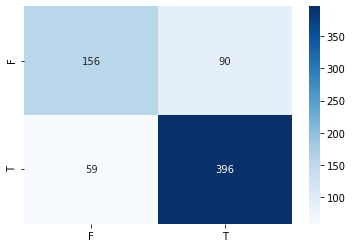

In [8]:
import seaborn as sns

count_values = list(map(lambda x: sum(x), conf_mat))

unique, counts = np.unique(np.array(test[result_column]), return_counts=True)
count_labels = dict(zip(counts, unique))

labels = []
for value in count_values:
    labels.append(count_labels[value])

sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

In [9]:
print(classification_report(test[result_column], predicted))

              precision    recall  f1-score   support

           F       0.73      0.63      0.68       246
           T       0.81      0.87      0.84       455

    accuracy                           0.79       701
   macro avg       0.77      0.75      0.76       701
weighted avg       0.78      0.79      0.78       701

